In [1]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

C:\Users\Tartiflettopolys\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
class Blurryer(nn.Module):
    def __init__(self) -> None:
        super(Blurryer, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Decoder
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)


    def forward(self, x:[torch.tensor]) -> [torch.tensor]:

        x0 = x

        # encoder
        x0 = self.conv1(x0)
        x0 = F.relu(x0)
        x0 = self.conv2(x0)
        x0 = F.relu(x0)
        x0 = self.maxPool1(x0)
        x0 = self.conv3(x0)
        x0 = F.relu(x0)
        x0 = self.maxPool2(x0)

        x1 = x0

        #decoder
        x1 = self.conv4(x1)
        x1 = F.relu(x1)
        x1 = self.upsample1(x1)
        x1 = self.conv5(x1)
        x1 = F.relu(x1)
        x1 = self.conv6(x1)
        x1 = F.relu(x1)
        x1 = self.upsample2(x1)

        return x1

class Denoiser(nn.Module):
    def __init__(self) -> None:
        super(Denoiser, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Decoder
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)


    def forward(self, x:[torch.tensor]) -> [torch.tensor]:

        x0 = x

        # encoder
        x0 = self.conv1(x0)
        x0 = F.relu(x0)
        x0 = self.conv2(x0)
        x0 = F.relu(x0)
        x0 = self.maxPool1(x0)
        x0 = self.conv3(x0)
        x0 = F.relu(x0)
        x0 = self.maxPool2(x0)

        x1 = x0

        #decoder
        x1 = self.conv4(x1)
        x1 = F.relu(x1)
        x1 = self.upsample1(x1)
        x1 = self.conv5(x1)
        x1 = F.relu(x1)
        x1 = self.conv6(x1)
        x1 = F.relu(x1)
        x1 = self.upsample2(x1)

        return x1

In [4]:
def load_dataset() -> [torch.tensor]:
    noisy_img = []

    noise_intensity_path = []
    directories = os.listdir(os.path.join(os.getcwd(), "Dataset", "noisy"))

    def compare(dir1:str, dir2:str) -> int:
        return int(dir1.replace("%", '')) - int(dir2.replace("%", ''))

    from functools import cmp_to_key
    directories = sorted(directories, key=cmp_to_key(compare))

    for directory in directories:
        path = os.path.join(os.getcwd(), "Dataset", "noisy", directory)
        noise_intensity_path.append(path)

    for _ in range(0, len(noise_intensity_path) + 1):
        noisy_img.append([])

    nb_img = len(os.listdir(noise_intensity_path[0]))
    for i in range(0, len(noise_intensity_path)):
        for j in range(1, nb_img + 1):
            image_path = os.path.join(noise_intensity_path[i], str(j) + ".jpg")
            image = torchvision.io.read_image(image_path)[:3,:,:]
            noisy_img[i].append(image)

    not_noisy_path = os.path.join(os.getcwd(), "Dataset", "64x64")
    for i in range(1, nb_img + 1):
        path = os.path.join(not_noisy_path, str(i) + ".jpg")
        image = torchvision.io.read_image(path)[:3,:,:]
        noisy_img[-1].append(image)

    return noisy_img

dataset = load_dataset()

In [13]:
def plot_dataset_sample(nb_sample:int = 1) -> None:
    nb_image = len(dataset[-1])
    
    for _ in range(0, nb_sample):
        randIndex = random.randint(0, nb_image)
        print(str(randIndex + 1) + ".jpg")
        img_to_plot = []
        for i in range(0, len(dataset)):
            img_to_plot.append(dataset[i][randIndex])

        for img in img_to_plot:
            plt.imshow(img.permute(1, 2, 0))
            plt.show()

nb_sample_to_plot = 0
plot_dataset_sample(nb_sample_to_plot)

In [15]:
# Train blurryer

lr = 0.00001
batch_size = 300
epochs = 100
print_epoch_interval = 5
test_proportion = 0.1
saving_model = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device : " + device)

Device : cuda


In [24]:
def train_blurryer(model:Blurryer, X_train:[torch.tensor], y_train:[torch.tensor]) -> Blurryer:

    X_train = (torch.stack(X_train).float() / 255.0).to(device)
    y_train = (torch.stack(y_train).float() / 255.0).to(device)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

    model = Blurryer()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.MSELoss()

    print("Start training Blurryer")
    for epoch in range(0, epochs):
        print_sample = epoch in [30, 50, 75, 100]
        for inputs_batch, expected_outputs_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(inputs_batch)
            loss = criterion(outputs_batch, expected_outputs_batch)
            loss.backward()
            optimizer.step()

            if print_sample:
                print_sample = False
                input = (255.0 * inputs_batch[0]).to(torch.uint8).to('cpu')
                output = (255.0 * outputs_batch[0]).to(torch.uint8).to('cpu')
                output_expected = (255.0 * expected_outputs_batch[0]).to(torch.uint8).to('cpu')
                plt.imshow(input.permute(1, 2, 0))
                plt.show()
                plt.imshow(output.permute(1, 2, 0))
                plt.show()
                plt.imshow(output_expected.permute(1, 2, 0))
                plt.show()


        if(epoch == 0 or  (epoch+1) % print_epoch_interval == 0 or epoch + 1 == epochs):
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    if saving_model:
        path = "./Models/Blurryer/blurryer.model"
        if os.path.isfile(path):
            os.remove(path)

        torch.save(model.state_dict(), path)
        print(f"Blurryer Saved!")

    return model


blurryer = Blurryer()

X = []
Y = []
for i in range(0, len(dataset[0])):
    X.append(dataset[10][i])
    Y.append(dataset[11][i])

X_train_blurryer, X_test_blurryer, y_train_blurryer, y_test_blurryer = train_test_split(X, Y, test_size = test_proportion, random_state=145)

blurryer = train_blurryer(blurryer, X_train_blurryer, y_train_blurryer)

Start training Blurryer


C:\Users\Tartiflettopolys\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [300, 3, 64, 64]

In [7]:
def load_blurryer() -> Blurryer:
    model = Blurryer()
    model.load_state_dict(torch.load(os.path.join(os.getcwd(), "Models", "Blurryer", "blurryer.model")))
    return model

blurryer = load_blurryer()

Image0


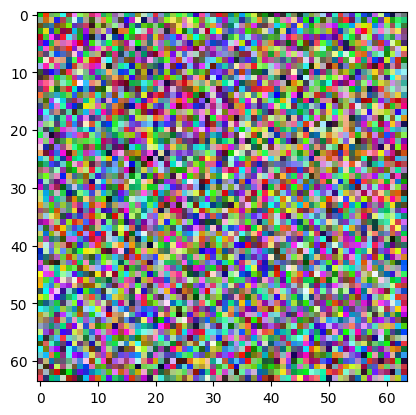

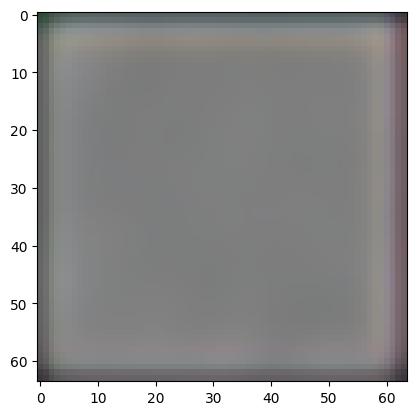

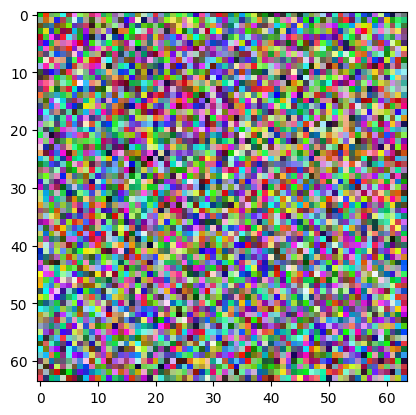

Image1


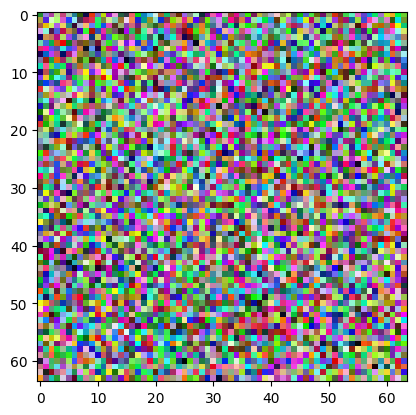

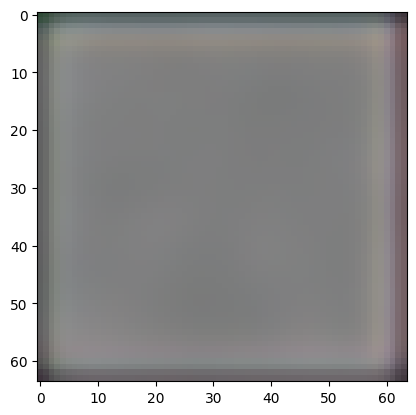

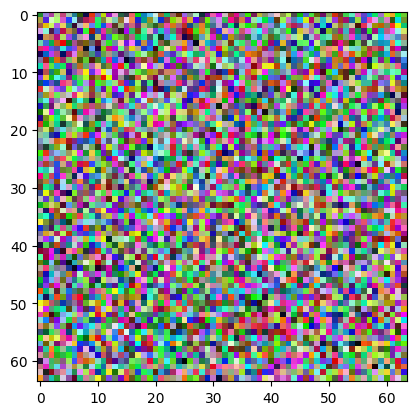

Image2


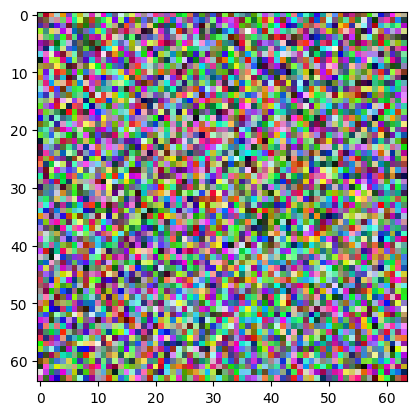

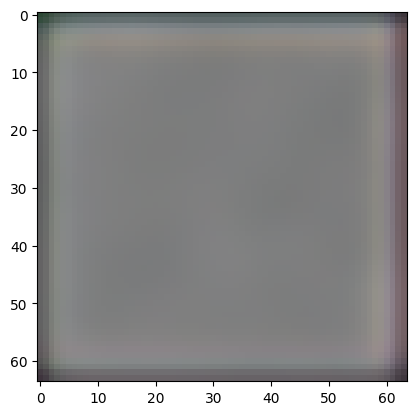

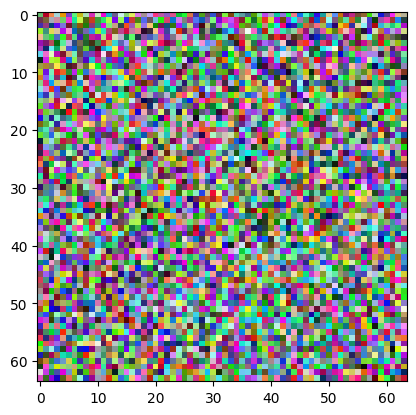

In [17]:
def test_blurryer(nb_images:int):

    images_inputs = []
    images_outputs = []
    expected_images_outputs = []
    blurryer.to(device)

    for i in range(0, nb_images):

        input = (torch.stack([X_test_blurryer[i]]).float() / 255.0).to(device)

        output = blurryer(input)

        outputs_images = (255.0 * output).to(torch.uint8).to('cpu')

        images_inputs.append(X_test_blurryer[i].permute(1, 2, 0))
        images_outputs.append(outputs_images[0].permute(1, 2, 0))
        expected_images_outputs.append(y_test_blurryer[i].permute(1, 2, 0))

    for i in range(0, len(images_inputs)):
        print(f"Image{i}")
        plt.imshow(images_inputs[i])
        plt.show()
        plt.imshow(images_outputs[i])
        plt.show()
        plt.imshow(expected_images_outputs[i])
        plt.show()

test_blurryer(3)

In [7]:
# Train denoisers

lr = 0.00001
batch_size = 300
epochs = 100
print_epoch_interval = 4
test_proportion = 0.1
saving_model = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device : " + device)

Device : cuda


In [8]:
def train_model(model:Denoiser, criterion:torch.nn.modules.loss, X_train:[torch.tensor], y_train:[torch.tensor], X_test:[torch.tensor], y_test:[torch.tensor], name:str) -> None:

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    X_train = (torch.stack(X_train).float() / 255.0).to(device)
    y_train = (torch.stack(y_train).float() / 255.0).to(device)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

    #X_test = torch.stack(X_test).float().to(device)
    #y_test = torch.stack(y_test).float().to(device)
    # test_dataset = TensorDataset(X_test, y_test)
    # test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

    print("Start training model : " + name)
    for epoch in range(0, epochs):
        for inputs_batch, expected_outputs_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(inputs_batch)
            loss = criterion(outputs_batch, expected_outputs_batch)
            loss.backward()
            optimizer.step()

        if(epoch == 0 or  (epoch+1) % print_epoch_interval == 0 or epoch + 1 == epochs):
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    if saving_model:
        if os.path.isfile(f"./Models/{name}.model"):
            os.remove(f"./Models/{name}.model")

        torch.save(model.state_dict(), f"./Models/{name}.model")
        print(f"Model {name} Saved!")

#train all models
models = []
X_tests = []
y_tests = []
criterion = nn.MSELoss()

for i in range(0, len(dataset) - 1):
    model = Denoiser()
    X_train, X_test, y_train, y_test = train_test_split(dataset[i], dataset[i + 1], test_size = test_proportion, shuffle=True, random_state=145)
    train_model(model, criterion, X_train, y_train, X_test, y_test, name = "diffuser" + str(i))
    models.append(model)
    X_tests.append(X_test)
    y_tests.append(y_test)


torch.Size([1154, 3, 64, 64])
Start training model : diffuser0
Epoch 1, Loss: 0.3173442780971527


KeyboardInterrupt: 

In [7]:
def load_models()->[Denoiser]:
    models = []
    nb_models = len(os.listdir(os.path.join(os.getcwd(), "Models", "Diffusers")))
    for i in range(0, nb_models):
        model = Denoiser()
        model.load_state_dict(torch.load(os.path.join(os.getcwd(), "Models", "Diffusers", "diffuser" + str(i) + ".model")))
        models.append(model)

    return models

models = load_models()

In [11]:
def compute_mean_loss() -> [float]:

    mean_loss = []

    for i in range(0, len(models)):
        loss = 0.0

        for k in range(0, len(X_tests[i])):
            inputs =  (torch.stack([X_tests[i][k]]).float() / 255.0).to(device)
            outputs_test = model(inputs)
            loss += criterion(inputs, outputs_test)

        loss /= float(len(X_tests[i]))
        mean_loss.append(float(loss))

    return mean_loss

mean_loss = compute_mean_loss()
print(mean_loss)

[0.3287632167339325, 0.3241576552391052, 0.3188270330429077, 0.3110227882862091, 0.30100107192993164, 0.2894038259983063, 0.27627766132354736, 0.2624082863330841, 0.24829944968223572, 0.2499428391456604, 0.22270922362804413, 0.2128671407699585, 0.20413489639759064]


Model number 0


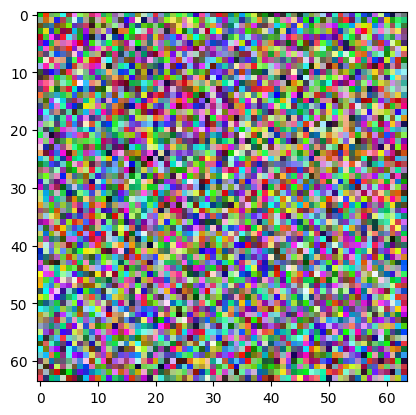

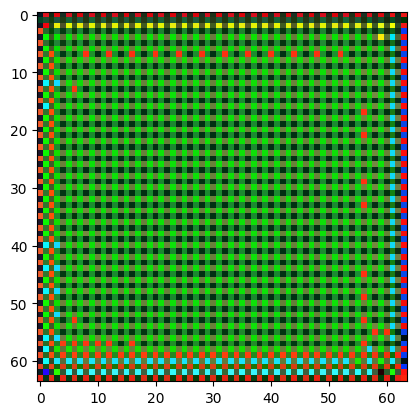

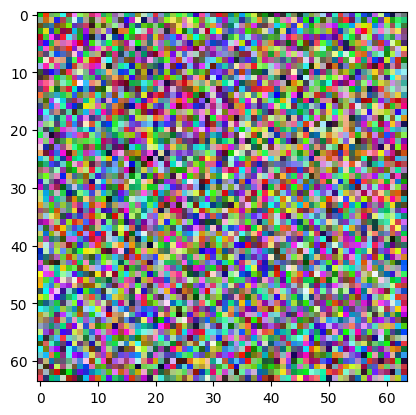

Model number 1


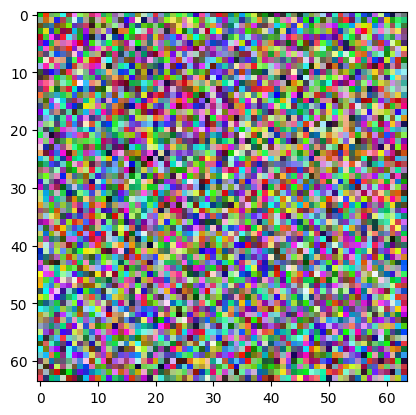

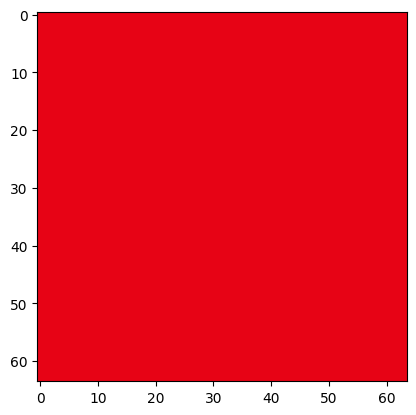

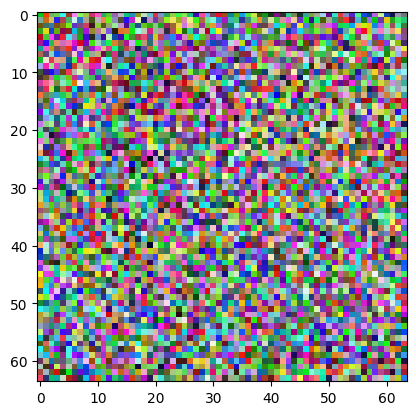

Model number 2


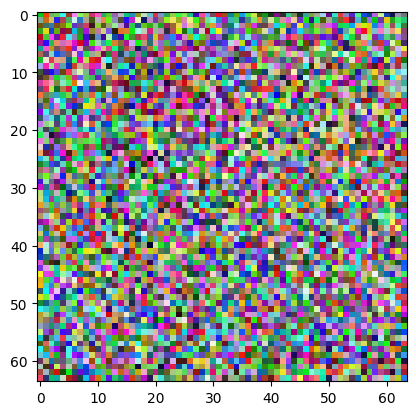

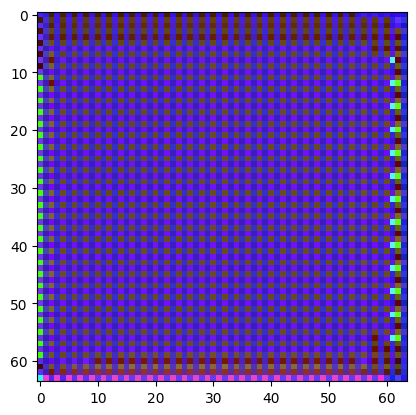

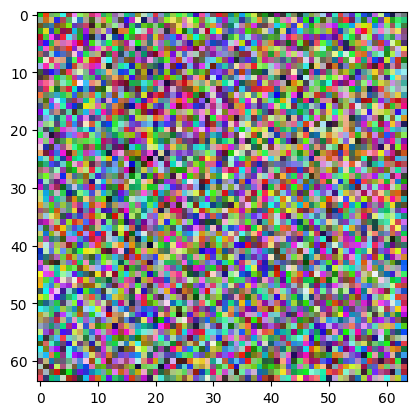

Model number 3


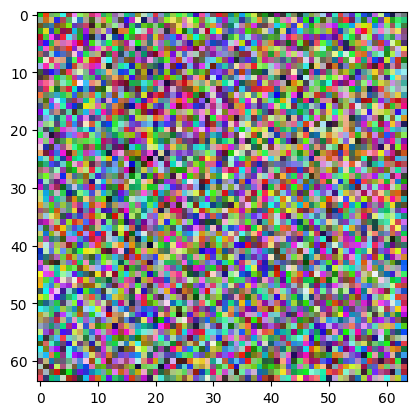

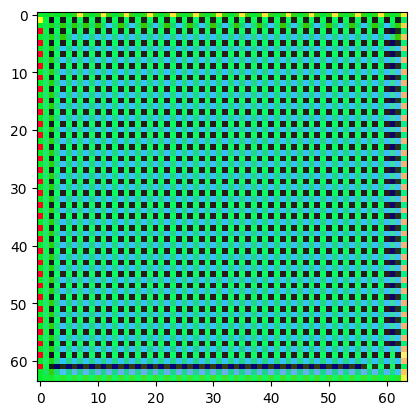

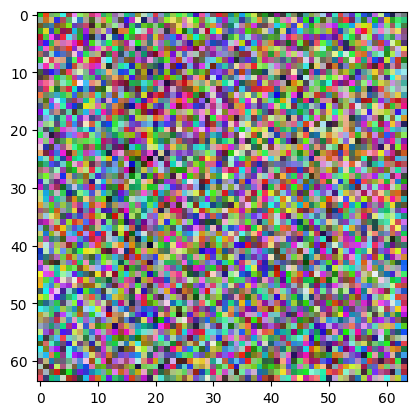

Model number 4


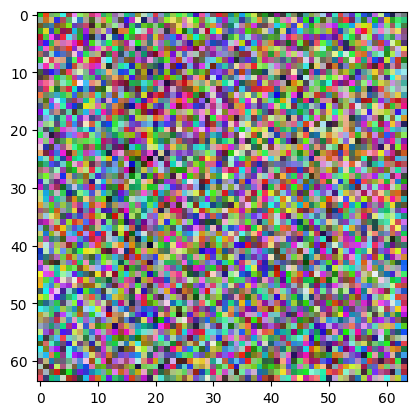

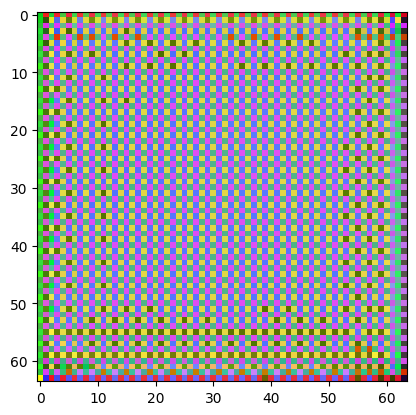

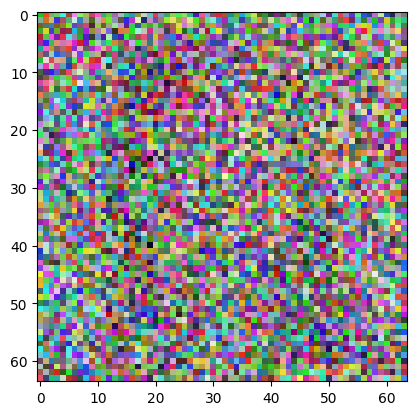

Model number 5


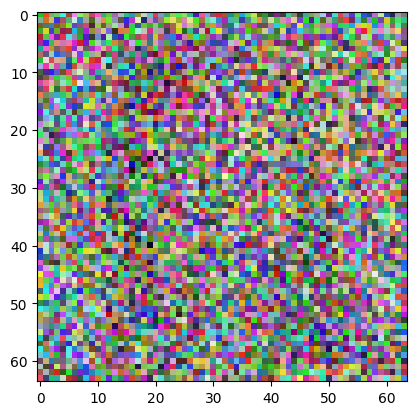

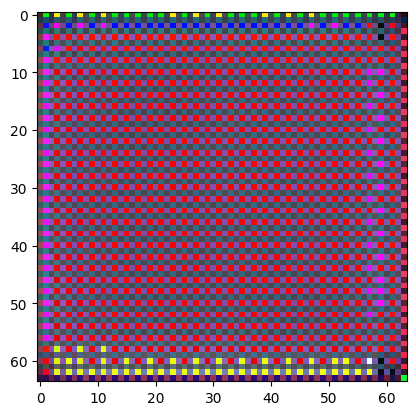

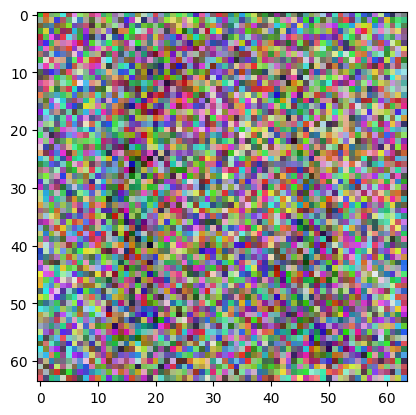

Model number 6


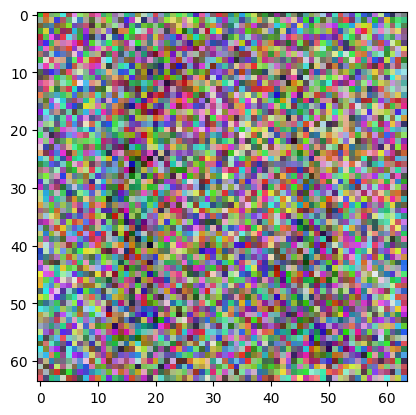

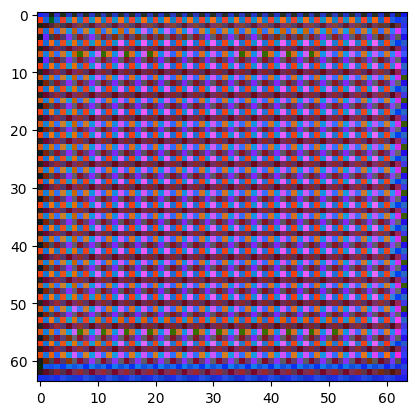

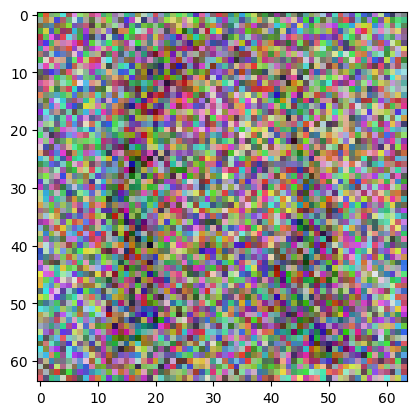

Model number 7


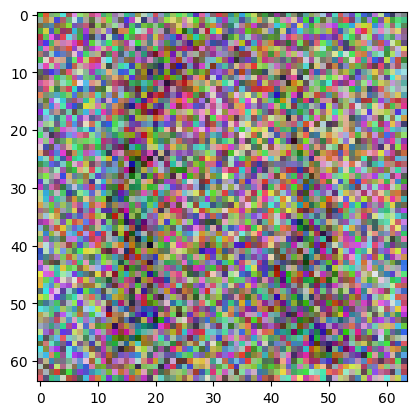

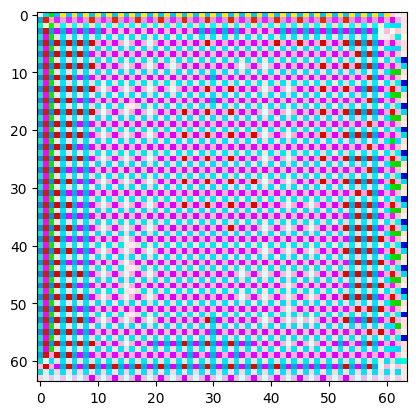

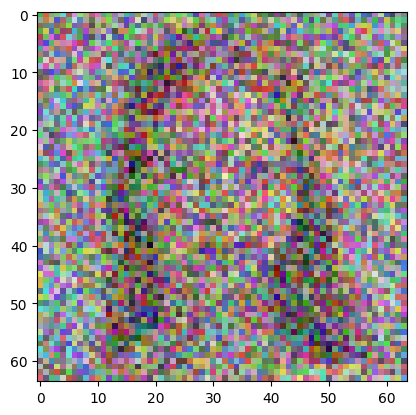

Model number 8


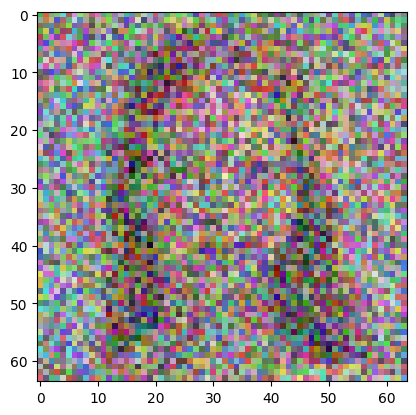

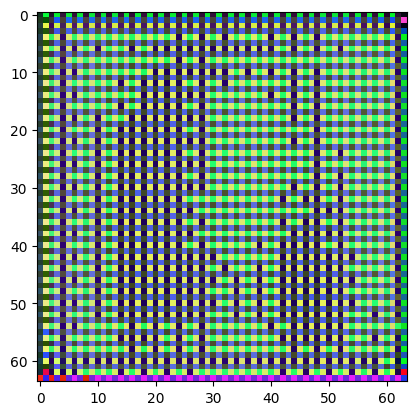

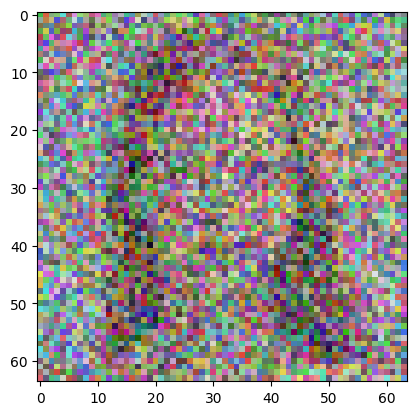

Model number 9


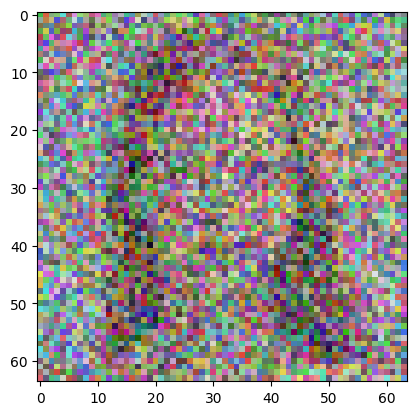

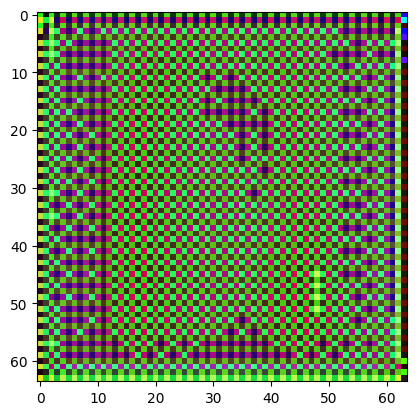

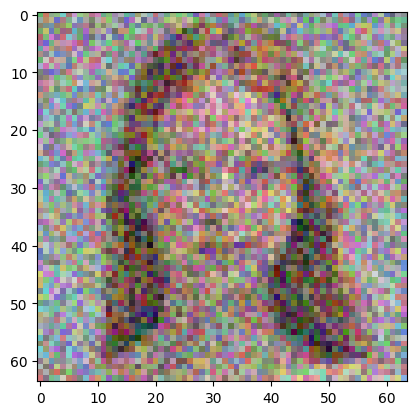

Model number 10


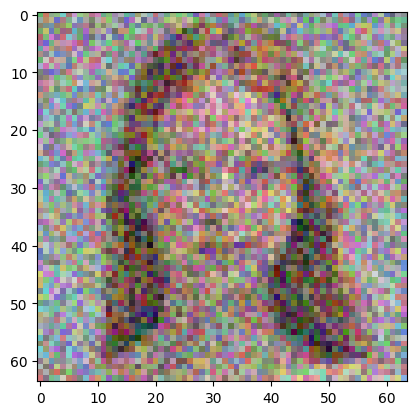

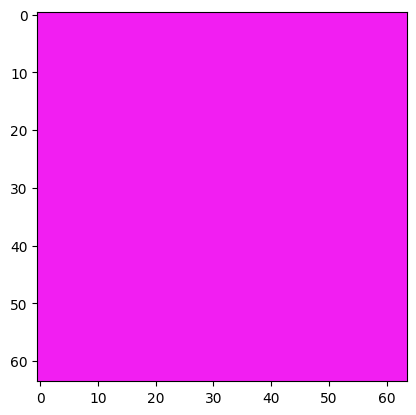

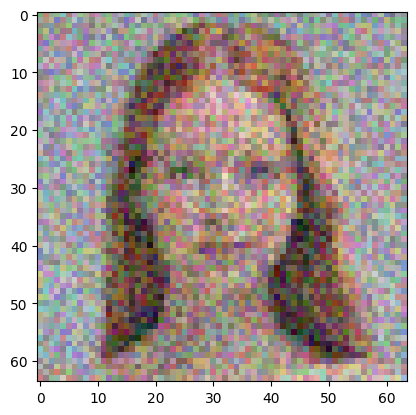

Model number 11


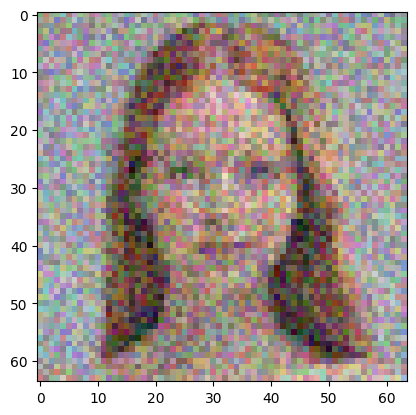

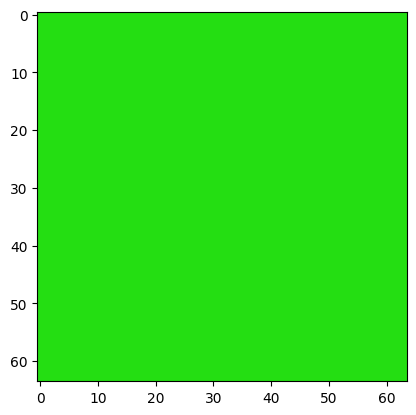

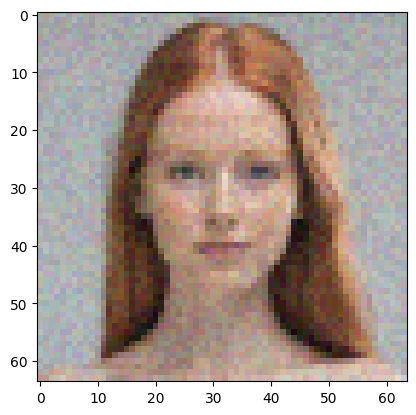

Model number 12


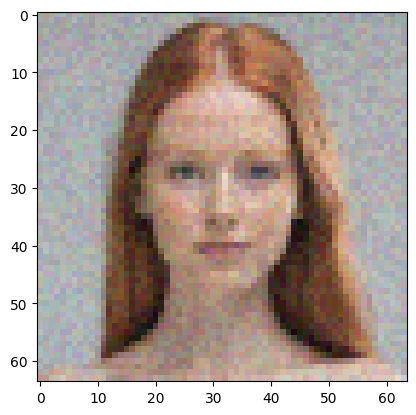

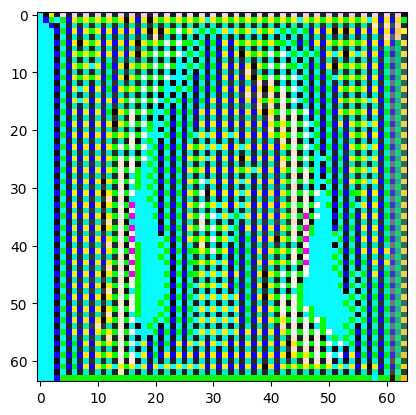

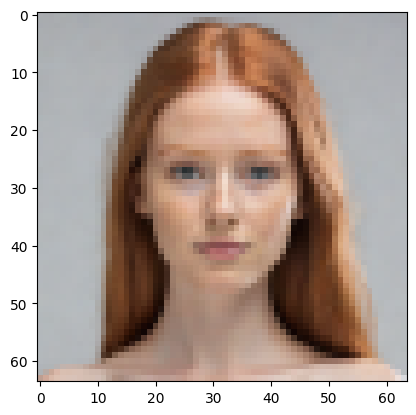

In [9]:
def test() -> None:    

    nb_img_test = 1

    for k in range(0, nb_img_test):

        images_inputs = []
        images_outputs = []
        expected_images_outputs = []

        for i in range(0, len(models)):
            model = models[i]
            model.to(device)

            test_image_noisy = [X_tests[i][k]]
            images_inputs.append(test_image_noisy[0].permute(1, 2, 0))

            inputs = (torch.stack(test_image_noisy).float() / 255.0).to(device)

            outputs_test = model(inputs)

            outputs_images = (255.0 * outputs_test).to(torch.uint8).to('cpu')

            images_outputs.append(outputs_images[0].permute(1, 2, 0))
            expected_images_outputs.append(y_tests[i][k].permute(1, 2, 0))
        
        for i in range(0, len(images_inputs)):
            print(f"Model number {i}")

            plt.imshow(images_inputs[i])
            plt.show()
            plt.imshow(images_outputs[i])
            plt.show()
            plt.imshow(expected_images_outputs[i])
            plt.show()

test()

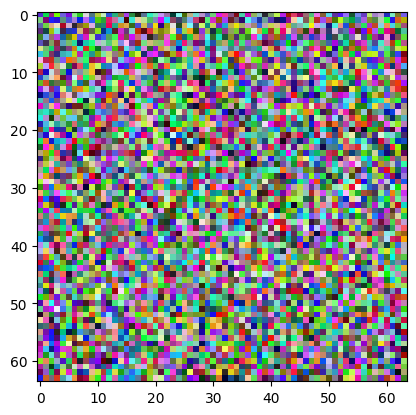

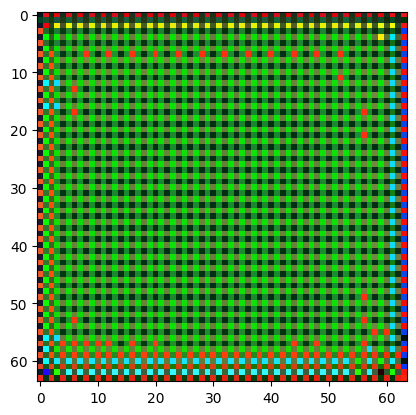

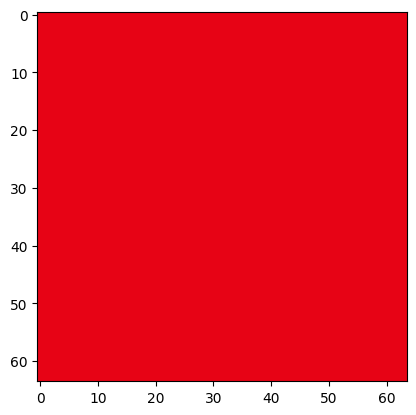

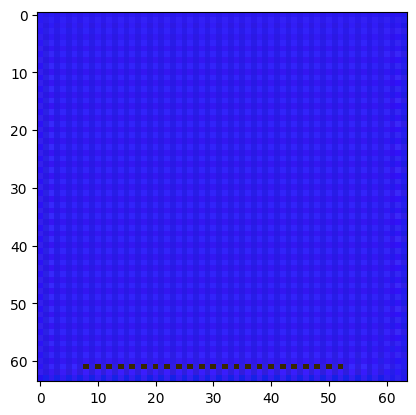

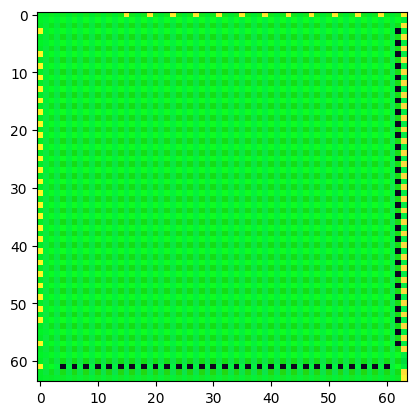

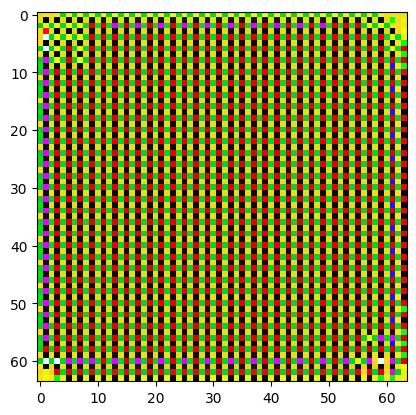

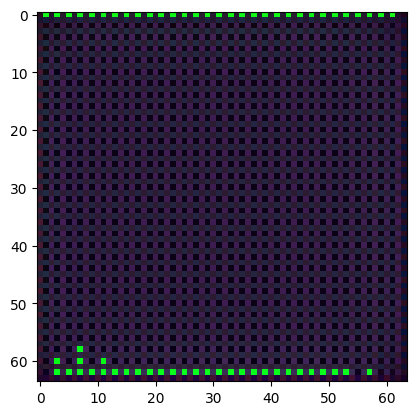

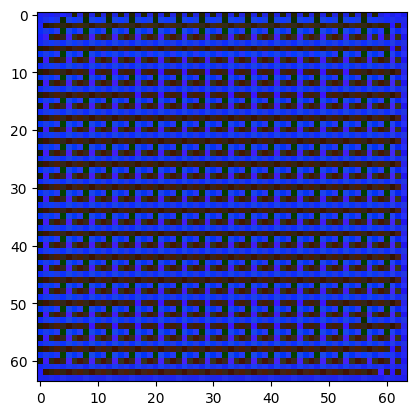

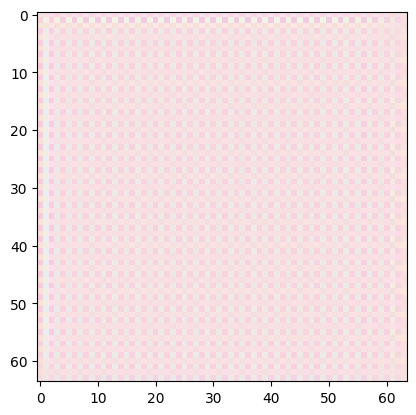

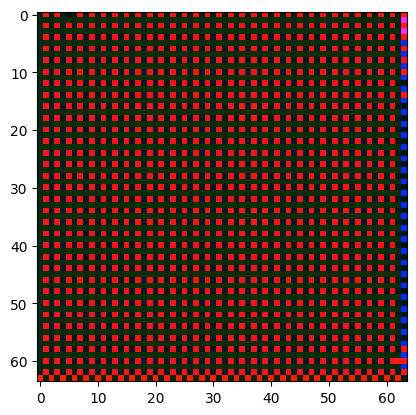

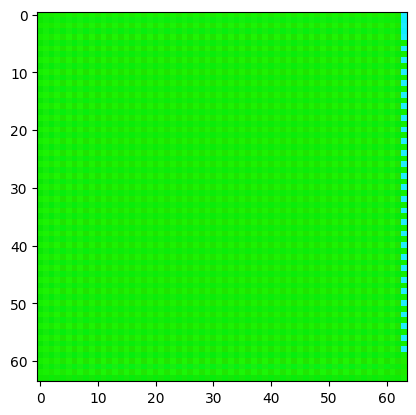

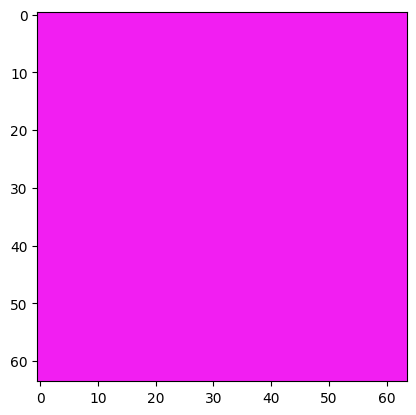

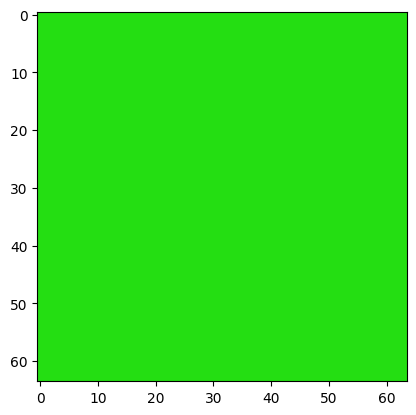

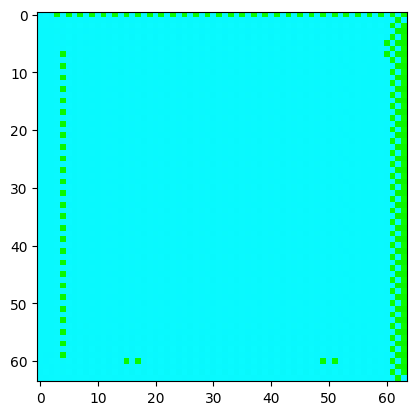

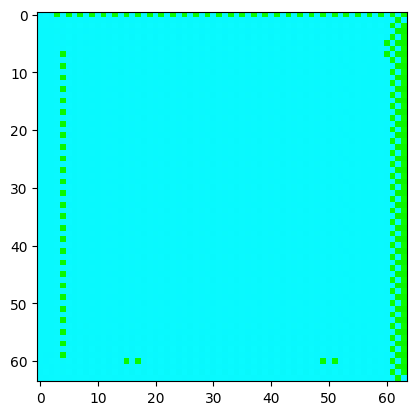

In [10]:
def evaluate(models:[Denoiser], show_intermediate_step = True) -> torch.tensor:

    def show_current_image(current_image:torch.tensor) -> None:
        tmp = (current_image[0] * 255.0).to(torch.uint8).to('cpu')
        plt.imshow(tmp.permute(1, 2, 0))
        plt.show()

    tmp_img = torch.tensor(np.random.rand(3, 64, 64))

    current_image = torch.stack([tmp_img]).float().to(device)
    if show_intermediate_step:
        show_current_image(current_image)

    for model in models:
        model.to(device)
        current_image = model(current_image)
        if show_intermediate_step:
            show_current_image(current_image)
    
    final_image = (current_image[0] * 255.0).to(torch.uint8).to('cpu')
    transform = torchvision.transforms.ToPILImage()
    pil_image = transform(final_image)

    image_name = "image" + str(len(os.listdir(os.path.join(os.getcwd(), "GeneratedImages")))) + ".jpg"
    path = os.path.join(os.getcwd(), "GeneratedImages", image_name)
    pil_image.save(path)

    return final_image.permute(1, 2, 0)

nb_evaluations = 1
for i in range(0, nb_evaluations):
    img = evaluate(models, True)
    plt.imshow(img)
    plt.show()